# Tree Based Methods
Random forest and adaboost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier

In [3]:
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
alldata = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv')
alldata['Agree'] = ~(alldata['True_state']^alldata['Alert'])

In [6]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
Trial                 4000 non-null int64
True_state            4000 non-null bool
Alert                 4000 non-null bool
Identification        4000 non-null bool
First_toggle_time     4000 non-null int64
RMS                   4000 non-null float64
Attention             4000 non-null float64
Click                 4000 non-null int64
Top_Left_Enemy        4000 non-null bool
Top_Right_Enemy       4000 non-null bool
Bottom_Left_Enemy     4000 non-null bool
Bottom_Right_Enemy    4000 non-null bool
Top_Left_Dark         4000 non-null bool
Top_Right_Dark        4000 non-null bool
Bottom_Left_Dark      4000 non-null bool
Bottom_Right_Dark     4000 non-null bool
Agree                 4000 non-null bool
dtypes: bool(12), float64(2), int64(3)
memory usage: 203.2 KB


In [7]:
abnormal = alldata[alldata['RMS']>60]
normal = alldata[alldata['RMS']<=60]

In [36]:
newdata = abnormal.append(normal.sample(n=160,random_state=2000))
newdata['performance'] = newdata['RMS'] <= 60

In [37]:
X = newdata.drop(['RMS','performance'],axis=1)
y = newdata['performance']

In [47]:
accuracy = []
auc = []
importance = pd.DataFrame(columns = X.columns)

In [48]:
states = np.arange(15,30)

In [49]:
for state in states:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=state,stratify=y)
    rf = RandomForestClassifier()
    searcher = GridSearchCV(rf, {'n_estimators':[10,30,50,100,200],'max_features':[3,4,5,6]})
    searcher.fit(X_train, y_train)
    importance.loc[state,] = searcher.best_estimator_.feature_importances_
    y_pred = searcher.predict(X_test)
    accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
    y_pred_prob = searcher.predict_proba(X_test)[:,1]
    auc.append(roc(y_test,y_pred_prob))

In [50]:
print('accuracy mean: ',np.mean(accuracy))
print('auc mean: ',np.mean(auc))
print('accuracy median: ',np.median(accuracy))
print('auc median: ',np.median(auc))

accuracy mean:  0.7020833333333333
auc mean:  0.781394675925926
accuracy median:  0.7083333333333334
auc median:  0.7821180555555556


In [51]:
auc

[0.7921006944444445,
 0.748263888888889,
 0.7404513888888888,
 0.783203125,
 0.8315972222222223,
 0.7623697916666666,
 0.7821180555555556,
 0.787326388888889,
 0.7408854166666666,
 0.8077256944444444,
 0.7664930555555556,
 0.8430989583333333,
 0.7571614583333334,
 0.7671440972222221,
 0.8109809027777779]

In [54]:
conclusion = importance.apply(np.mean)

In [61]:
conclusion.sort_values('Importance')

,Importance
Bottom_Left_Enemy,0.002990
Bottom_Right_Enemy,0.007159
Top_Right_Enemy,0.010781
Top_Left_Enemy,0.011291
Identification,0.012781
True_state,0.013992
Agree,0.020608
Top_Left_Dark,0.022122
Alert,0.023842
Bottom_Right_Dark,0.026205


In [58]:
conclusion = pd.DataFrame(conclusion,columns=['Importance'])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=30,stratify=y)
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = np.sum(y_pred==y_test)/len(y_pred)
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [68]:
accuracy

0.71875

In [69]:
outcome = pd.DataFrame({'pred':y_pred,'y_test':y_test})

In [70]:
np.sum(outcome['y_test'])

48

In [71]:
len(outcome)

96

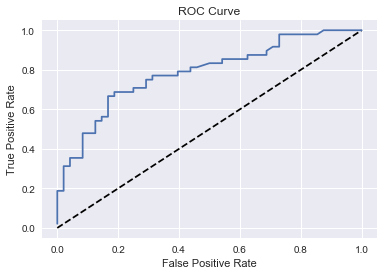

In [72]:
pp = PdfPages('Sample_ROC_rf.pdf')
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(pp,format='pdf')
pp.close()

In [73]:
roc(y_test, y_pred_prob)

0.78515625

In [29]:
accuracy = []
auc = []

In [30]:
for state in states:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=state,stratify=y)
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators = 100, random_state=1234)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
    y_pred_prob = ada.predict_proba(X_test)[:,1]
    auc.append(roc(y_test,y_pred_prob))

In [31]:
np.mean(accuracy)

0.6673611111111111

In [32]:
np.mean(auc)

0.7093894675925924

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=30,stratify=y)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators = 100, random_state=1234)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
accuracy = np.sum(y_pred==y_test)/len(y_pred)
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [34]:
y_pred_prob

array([4.93722590e-02, 3.27031351e-07, 9.99476953e-01, 9.99875051e-01,
       3.10684971e-02, 7.52437182e-03, 9.89586004e-01, 1.00630649e-01,
       9.97508023e-01, 9.99999996e-01, 3.12936178e-06, 9.99995257e-01,
       9.85344045e-01, 9.99999994e-01, 2.07177162e-01, 5.72266735e-06,
       9.99996992e-01, 8.77686189e-02, 4.20342677e-02, 7.36534231e-05,
       2.13999200e-04, 9.99603418e-01, 1.40322101e-01, 3.26794204e-05,
       3.59144126e-04, 9.99999347e-01, 8.54795173e-01, 9.99999989e-01,
       7.76698100e-04, 5.61617738e-01, 9.36953618e-01, 9.99982616e-01,
       2.89013163e-06, 9.97323649e-01, 9.99999991e-01, 4.93953455e-02,
       9.98652654e-01, 9.80641484e-01, 9.99999715e-01, 8.29841722e-01,
       1.59760966e-01, 1.58536430e-05, 1.11912625e-02, 2.45393729e-08,
       9.68164964e-01, 9.99999991e-01, 5.17521327e-01, 4.45298854e-09,
       1.43066535e-07, 9.91838333e-05, 9.99993233e-01, 3.86695814e-04,
       9.99293638e-01, 4.63208229e-06, 2.53023865e-03, 3.20310679e-02,
      

In [30]:
accuracy

0.6650717703349283

Text(0.5,1,'ROC Curve')

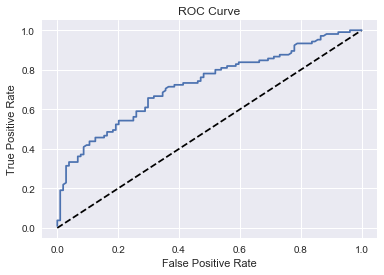

In [31]:
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

In [32]:
roc(y_test, y_pred_prob)

0.7244505494505495